#                              Ensemble:
                             

Ensemble means that multiple models being used together so as to build a more powerful model. The more diffetent the models are, the more powerful and more creative the output is.

# What is bagging??..

It is also known as bootstrap aggregation.
-----------
1. We divide the dataset in to multiple small datasets using Randomization.
2. Here we do sampling with replacement. That is, we don't delete the points we take for our sample dataset from the original dataset.
3. Different sampled datasets give different models.
4. Combining all the models is known as AGGREGATION.


------------------------------------------------------------------------


Since each of the models see only asample of data, so when the points change only some of the models change thus the overall dataset remains unchanged.


Bagging can reduce the variance in a model without impacting the bias.

# Random Forests:

1. We pick a random number generator, take a point and put it.
2. Here we sample both rows and coloumns.
3. For random forests, the models are DECISION TREES of reasonable depth.
4. If we subtract the original dataset from the sampled dataset, we can the OUT OF BAG points, which can be used for cross validation.
5. The baselearners(hyper-parameters) are directly proportional to the variance.
6. If the OOb is set to true, then for every baselearner, it would report the model score on oob dataset.



# What is Boosting??..

# $$F_k(x)=\sum_{i=0}^k \alpha_0*h_0(x)$$

In short, it reduces the bias keeping the variance low.
h_i(x) is trained on x_i and err(i), where err(i) is the residual error.


-------------------------------



Negative derivative of my loss function can be thought of as a Residual loss. It is often known as pesuodo residual. 
We train on Pesuodo residual because it lets us minimize any loss function of our choice as long as it is differentiable.

$$-\frac{\partial L}{\partial F_k(X_i)} = 2((Y_i - F_K(X_i))$$

# Gradient Boosting..

1. Here the learning rate is 'v' and it lies between {0,1}
2. It is also known as the shinkage rate.
3. Each of the base learners is a DECISION TREE with a high bias and low variance.


# Loading the data:

In [2]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

# Amazon Fine Food Reviews Analysis
----------------------------------------------------

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

    Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3





# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return -1
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


Data Cleansing : deduplication
---------------------------------------------

(1) It is based more on how we observe or interpret the data. 
(2) Basically it is cleaning or filtering the data.

we don't want to feed grbage to our model.. Do we?
--------------------------------------------------------------------------
So we remove duplicates from our entry

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


 1    307061
-1     57110
Name: Score, dtype: int64

How to convert Text to Vector?? Text Preprocessing: Stemming, stop-word removal and Lemmatization.
-------------



Here, we determine a review by score. But what if a user had mistakernly put a 5 star review but was not at all satisfied with the product? We might find such cases so the most importrant factor in determining the outcome of a review is either the text of the review or the summary text.

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative review


In [10]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'below', 'few', 'haven', 'which', 'ma', 'at', 'because', "doesn't", 'don', 'me', 'not', 'those', 'off', 're', "haven't", 'yourself', 'most', 'hadn', "you'd", 'what', 'why', 'll', 'then', 'weren', 'did', 'theirs', 'doing', "hasn't", 'until', 'an', 'before', 'wouldn', 'are', 'they', 'here', 'once', 'does', 'but', 'than', 'should', 'is', 'above', 'he', 'such', 'we', 'ours', "weren't", "mustn't", 'just', 'there', 'you', 'into', 'again', "shan't", 'needn', 'she', 'your', "wasn't", 'our', 'her', 'through', 'own', "hadn't", 'very', "you've", "should've", 'more', "that'll", 'only', 'be', 'couldn', 'down', 'isn', 'or', 'this', 'can', 'same', 'by', 'as', 'too', 'each', 'hers', "aren't", 'his', 'over', 'them', 'myself', 'being', 'wasn', 'been', 'it', 'having', 'doesn', 'their', 'him', 'now', "shouldn't", 'out', 'any', 'both', 'didn', "you're", 'was', 'ain', 'other', "won't", 'a', 'up', 'were', 'do', 'nor', 's', 'if', 'am', "she's", 'its', 'yourselves', 'y', 'these', 'themselves', 'where', 'shoul

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase


i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Summary'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['Summary']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['Summary']=final['Summary'].str.decode("utf-8")

In [16]:
final['New'] = final['Summary'] + final['CleanedText']

In [17]:
final = final.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Text'], axis = 1)
final.head(3)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,1,939340800,everi book educ,witti littl book make son laugh loud recit car...,everi book educwitti littl book make son laugh...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",1,1096675200,mmmm chicken soup,young boy describ use chicken soup rice month ...,mmmm chicken soupyoung boy describ use chicken...
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,1,1291075200,good children,classic children book cant wrong read kid orde...,good childrenclassic children book cant wrong ...


In [18]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [19]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,CleanedText,New
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,1,939340800,everi book educ,witti littl book make son laugh loud recit car...,everi book educwitti littl book make son laugh...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",1,1096675200,mmmm chicken soup,young boy describ use chicken soup rice month ...,mmmm chicken soupyoung boy describ use chicken...
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,1,1291075200,good children,classic children book cant wrong read kid orde...,good childrenclassic children book cant wrong ...


In [20]:
final = final.sample(n = 100000, replace = True) # Sampling 100k rows 
final = pd.DataFrame(final)
final.head(5)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,CleanedText,New
179610,194823,B001FA1DIM,A1GWZ75BJ1INV3,Leslie Noland,1,1325980800,worth chocol macadamia,brother gave box macadamia nut pick trip hawai...,worth chocol macadamiabrother gave box macadam...
71667,78027,B0002QEK7Q,AP42RLGK0X60P,A. Wallace,1,1187481600,best dijon rate cook illustr,read review found true great balanc acid hot f...,best dijon rate cook illustrread review found ...
380555,411485,B000HH0C6S,AB1LFN1PES2E,Andrew1503,-1,1327881600,would play,dvd fit dvd player excit movi disappoint perha...,would playdvd fit dvd player excit movi disapp...
488451,528177,B002GWMDLY,A1H846C0DZ3GVF,my3cairns,-1,1345766400,favorit coffe,previous purchas coffe bean direct decaf espre...,favorit coffeprevious purchas coffe bean direc...
140786,152789,B000FDMLVI,APHJ2Y833O6DW,F. Lentz,1,1346889600,perfect everytim,huge fan hodgson mill flour pasta product purc...,perfect everytimhuge fan hodgson mill flour pa...


In [21]:
X = final['New']
X.head()

179610    worth chocol macadamiabrother gave box macadam...
71667     best dijon rate cook illustrread review found ...
380555    would playdvd fit dvd player excit movi disapp...
488451    favorit coffeprevious purchas coffe bean direc...
140786    perfect everytimhuge fan hodgson mill flour pa...
Name: New, dtype: object

In [22]:
Y = final['Score']

Y.head()

179610    1
71667     1
380555   -1
488451   -1
140786    1
Name: Score, dtype: int64

In [39]:
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

In [24]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000,)
Test Data Size:  (30000,)


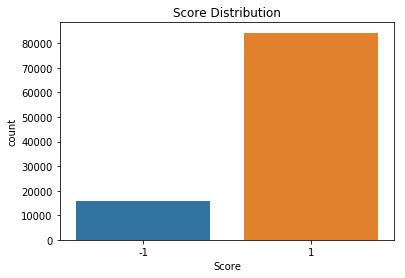

In [25]:

ax = plt.axes()
sns.countplot(final.Score,ax=ax)
ax.set_title('Score Distribution')
plt.show()


Bag Of Words (BoW) :
-----------

Bag of Words constructs a dictionsry of all the words in the document. A corpous is defined as a set of documents/reviews.
It converts all the words in the document into a vector each word having a different dimension. Each cell in the vector corresponds to the no of times a word occurs in the document.
 Similar texts result in closer distances between two vectors. Although BoW has its own limitations.


In [26]:
#BoW

count_vect = CountVectorizer(max_features = 3000) #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])


print('\n\nTEST: \n------------------------------------------------------------------------------------------------------\n\n')


print("the type of count vectorizer ",type(X_test_bow))
print("the shape of out text BOW vectorizer ",X_test_bow.get_shape())
print("the number of unique words ", X_test_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 3000)
the number of unique words  3000


TEST: 
------------------------------------------------------------------------------------------------------


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 3000)
the number of unique words  3000


# Normalization:

In [27]:
from sklearn import preprocessing

X_train_bow = preprocessing.normalize(X_train_bow)
print(X_train_bow.shape)

(70000, 3000)


In [28]:
X_test_bow = preprocessing.normalize(X_test_bow)
print(X_test_bow.shape)


(30000, 3000)


In [29]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [30]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 3)

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

# Random forest:

In [42]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

In [50]:
%%time


grid = sp_randint(2,50)
clf = RandomForestClassifier(class_weight = 'balanced')
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model.fit(X_train_bow,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 43, 'max_depth': 46}
best est : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=46, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=43, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Accuracy: 93.66%
CPU times: user 22.7 s, sys: 116 ms, total: 22.9 s
Wall time: 1min 11s


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 89.783%
Error : 10.217%
F1-Score on test set: 0.897
Precision on test set: 0.897
Recall on test set: 0.898
TPR is 0.9421683885524285
TNR is 0.6613890648089508
FPR is 0.3386109351910492
FNR is 0.05783161144757155
CPU times: user 44.5 s, sys: 160 ms, total: 44.7 s
Wall time: 12.3 s


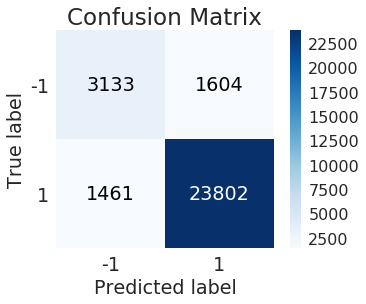

In [54]:
%%time

clf = RandomForestClassifier(n_estimators= 43, max_depth = 46, class_weight = 'balanced',  bootstrap = True, 
                             oob_score= True, n_jobs= -1)
clf.fit(X_train_bow, Y_train);
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

In [82]:
def plot_f1_hyper(model):

    x=[]
    y=[]
    for a in model.grid_scores_:
        x.append(a[0]['n_estimators']) 
        y.append(a[1])
    plt.xlim(2,50)
    plt.ylim(0,1)
    plt.xlabel("max depth",fontsize=15)
    plt.ylabel("f1-score")
    plt.title('F1 Score v/s Max Depth')
    plt.plot(x,y)
    plt.show()

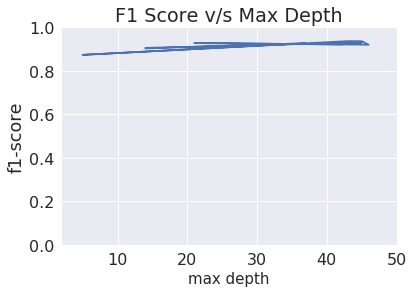

In [79]:
plot_f1_hyper(model)

In [35]:
from sklearn.tree.export import export_graphviz
from io import StringIO


In [36]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

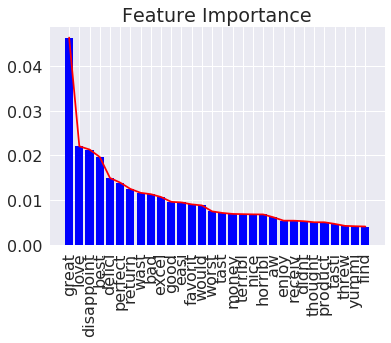

In [83]:
feat =  clf.feature_importances_
# Sort feature feat in descending order
feat_slice = np.argsort(feat)[::-1][:30]

all_feat = count_vect.get_feature_names()


# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(30), feat[feat_slice], color = 'blue')
plt.plot(range(30), feat[feat_slice], color = 'red')
# Add feature all_feat as x-axis labels
all_feat = np.array(all_feat)
plt.xticks(range(30), all_feat[feat_slice], rotation=90)

# Show plot
plt.show()

In [84]:
b = all_feat[feat_slice]

In [85]:
b = pd.DataFrame(b)
b.head(20)

,0
0,great
1,love
2,disappoint
3,best
4,delici
5,perfect
6,return
7,wast
8,bad
9,excel


In [90]:
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

Word Cloud:


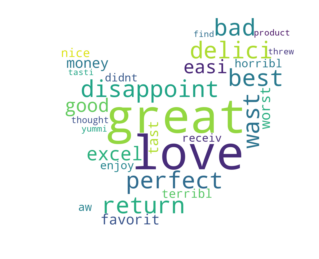

In [98]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image




all_feat = count_vect.get_feature_names()
my_mask = np.array(Image.open('tweet.png'))
wc = WordCloud(background_color="white", mask = my_mask)
wc.generate(str(b))
print("Word Cloud:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


# Gradient Boost:

In [100]:
%%time


grid = sp_randint(2,50)
clf =  GradientBoostingClassifier()
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model.fit(X_train_bow,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 37, 'max_depth': 21}
best est : GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=21,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=37,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Best Accuracy: 93.93%
CPU times: user 4min 3s, sys: 385 ms, total: 4min 3s
Wall time: 33min 41s


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 90.273%
Error : 9.727%
F1-Score on test set: 0.891
Precision on test set: 0.899
Recall on test set: 0.903
TPR is 0.9846019870957526
TNR is 0.4661177960734642
FPR is 0.5338822039265357
FNR is 0.015398012904247318
CPU times: user 3min 59s, sys: 43.7 ms, total: 3min 59s
Wall time: 3min 58s


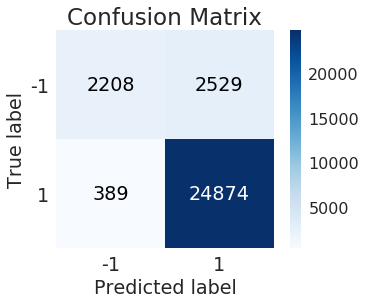

In [104]:
%%time

clf =  GradientBoostingClassifier(n_estimators= 37, max_depth = 21)
clf.fit(X_train_bow, Y_train);
Y_pred = clf.predict(X_test_bow)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

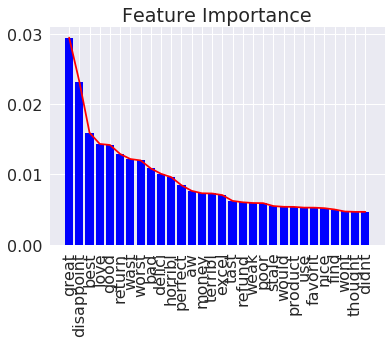

In [105]:
feat =  clf.feature_importances_
# Sort feature feat in descending order
feat_slice = np.argsort(feat)[::-1][:30]

all_feat = count_vect.get_feature_names()


# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(30), feat[feat_slice], color = 'blue')
plt.plot(range(30), feat[feat_slice], color = 'red')
# Add feature all_feat as x-axis labels
all_feat = np.array(all_feat)
plt.xticks(range(30), all_feat[feat_slice], rotation=90)

# Show plot
plt.show()

In [106]:
b = all_feat[feat_slice]

In [107]:
b = pd.DataFrame(b)
b.head(20)

,0
0,great
1,disappoint
2,best
3,love
4,good
5,return
6,wast
7,worst
8,bad
9,delici


Word Cloud:


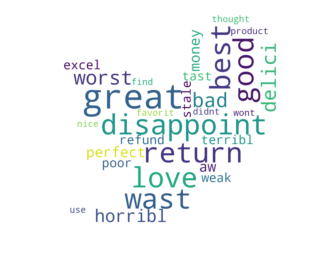

In [109]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image




all_feat = count_vect.get_feature_names()
my_mask = np.array(Image.open('tweet.png'))
wc = WordCloud(background_color="white", mask = my_mask)
wc.generate(str(b))
print("Word Cloud:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# TfIDF combination:
------------

In [118]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), max_features = 3000)
X_train_tf = tf_idf_vect.fit_transform(X_train)

X_test_tf = tf_idf_vect.transform(X_test)

In [119]:
from sklearn import preprocessing

X_train_tf = preprocessing.normalize(X_train_tf)
print(X_train_tf.shape)




(70000, 3000)


In [120]:

X_test_tf = preprocessing.normalize(X_test_tf)
print(X_test_tf.shape)

(30000, 3000)


In [121]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[20:40])

some sample features(unique words in the corpus) ['add', 'add littl', 'add water', 'addict', 'addit', 'adjust', 'admit', 'ador', 'adult', 'advantag', 'advertis', 'advis', 'affect', 'afford', 'afraid', 'afternoon', 'aftertast', 'afterward', 'agav', 'age']


In [124]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(X_train_tf[1,:].toarray()[0],features,25)

In [125]:
print(top_tfidf)

         feature     tfidf
0       reaction  0.444697
1          broth  0.429892
2          grain  0.349169
3         cannot  0.344213
4         gluten  0.311905
5           kind  0.293868
6            far  0.278943
7            got  0.261653
8         flavor  0.162593
9           tast  0.143822
10         flour  0.000000
11          foil  0.000000
12        folger  0.000000
13         focus  0.000000
14        fluffi  0.000000
15        flower  0.000000
16           zip  0.000000
17         floor  0.000000
18       florida  0.000000
19        follow  0.000000
20           fli  0.000000
21     flax seed  0.000000
22          flax  0.000000
23       flavour  0.000000
24  flavor would  0.000000


# Random Forest:

In [126]:
%%time


grid = sp_randint(2,50)
clf = RandomForestClassifier(class_weight = 'balanced')
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model.fit(X_train_tf,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 22, 'max_depth': 46}
best est : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=46, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=22, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Accuracy: 93.79%
CPU times: user 12.9 s, sys: 116 ms, total: 13 s
Wall time: 1min 6s


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 89.530%
Error : 10.470%
F1-Score on test set: 0.896
Precision on test set: 0.897
Recall on test set: 0.895
TPR is 0.9347662589557851
TNR is 0.6848216170572092
FPR is 0.31517838294279077
FNR is 0.06523374104421487
CPU times: user 21 s, sys: 143 ms, total: 21.2 s
Wall time: 6.58 s


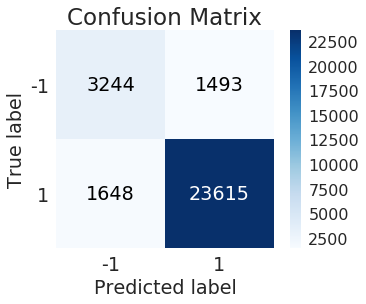

In [127]:
%%time

clf = RandomForestClassifier(n_estimators= 22, max_depth = 46, class_weight = 'balanced',  bootstrap = True, 
                             oob_score= True, n_jobs= -1)
clf.fit(X_train_tf, Y_train);
Y_pred = clf.predict(X_test_tf)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

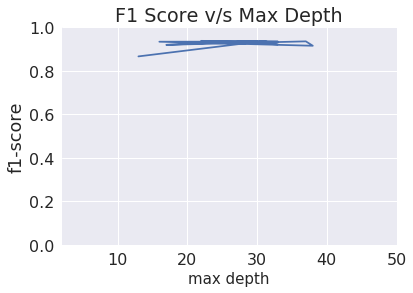

In [128]:
plot_f1_hyper(model)

In [129]:
all_features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[0:40])

some sample features(unique words in the corpus) ['abl', 'abl find', 'abl get', 'absolut', 'absolut best', 'absolut delici', 'absolut love', 'absorb', 'acai', 'accept', 'accord', 'acid', 'acquir', 'across', 'act', 'activ', 'actual', 'actual tast', 'ad', 'ad sugar', 'add', 'add littl', 'add water', 'addict', 'addit', 'adjust', 'admit', 'ador', 'adult', 'advantag', 'advertis', 'advis', 'affect', 'afford', 'afraid', 'afternoon', 'aftertast', 'afterward', 'agav', 'age']


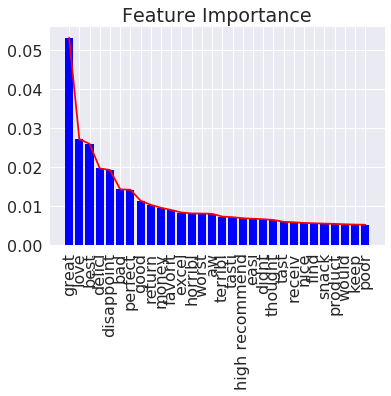

In [131]:
feat =  clf.feature_importances_


# Sort feature feat in descending order
feat_slice = np.argsort(feat)[::-1][:30]



# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(30), feat[feat_slice], color = 'blue')
plt.plot(range(30), feat[feat_slice], color = 'red')
# Add feature all_features as x-axis labels
all_features = np.array(all_features)
plt.xticks(range(30), all_features[feat_slice], rotation=90)

# Show plot
plt.show()



In [132]:
c = all_features[feat_slice]
c = pd.DataFrame(c)
c.head()

,0
0,great
1,love
2,best
3,delici
4,disappoint


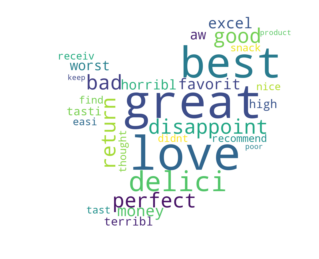

In [133]:
my_mask = np.array(Image.open('tweet.png'))
wc = WordCloud(background_color="white", mask = my_mask)
wc.generate(str(c))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


# Gradient Boosting:

In [134]:
%%time


grid = sp_randint(2,50)
clf =  GradientBoostingClassifier()
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model.fit(X_train_tf,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 47, 'max_depth': 15}
best est : GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=47,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Best Accuracy: 94.00%
CPU times: user 4min 2s, sys: 340 ms, total: 4min 3s
Wall time: 24min 58s


Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 90.293%
Error : 9.707%
F1-Score on test set: 0.890
Precision on test set: 0.900
Recall on test set: 0.903
TPR is 0.9866603332937498
TNR is 0.45640700865526707
FPR is 0.5435929913447329
FNR is 0.013339666706250248
CPU times: user 4min 1s, sys: 49 ms, total: 4min 1s
Wall time: 4min 1s


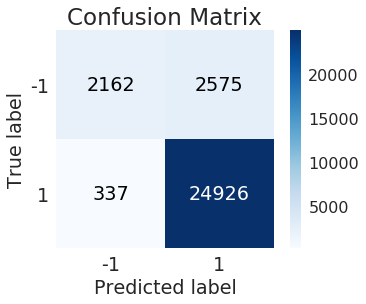

In [135]:
%%time

clf =  GradientBoostingClassifier(n_estimators= 47, max_depth = 15)
clf.fit(X_train_tf, Y_train);
Y_pred = clf.predict(X_test_tf)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

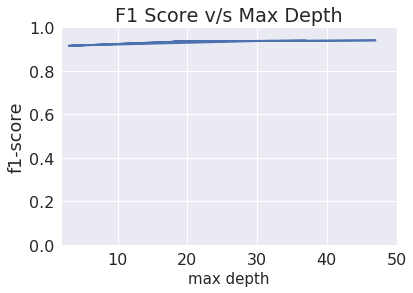

In [136]:
plot_f1_hyper(model)

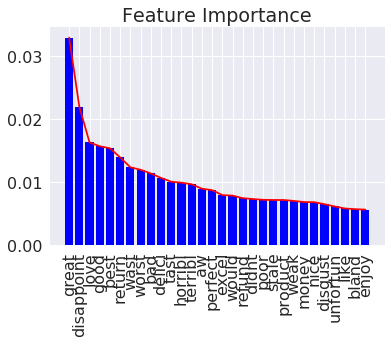

In [137]:
feat =  clf.feature_importances_


# Sort feature feat in descending order
feat_slice = np.argsort(feat)[::-1][:30]



# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(30), feat[feat_slice], color = 'blue')
plt.plot(range(30), feat[feat_slice], color = 'red')
# Add feature all_features as x-axis labels
all_features = np.array(all_features)
plt.xticks(range(30), all_features[feat_slice], rotation=90)

# Show plot
plt.show()


In [139]:
d = all_features[feat_slice]
d = pd.DataFrame(d)
d.head()

,0
0,great
1,disappoint
2,love
3,good
4,best


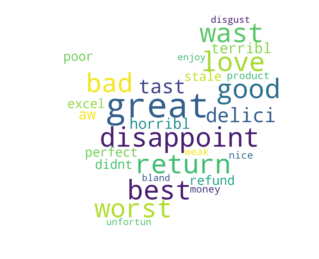

In [140]:
my_mask = np.array(Image.open('tweet.png'))
wc = WordCloud(background_color="white", mask = my_mask)
wc.generate(str(d))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


# Word to vec:
------------



In [57]:
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [58]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size = 50, workers=4)

In [59]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12576
sample words  ['havent', 'use', 'cook', 'good', 'host', 'book', 'review', 'benefit', 'folk', 'consum', 'place', 'oil', 'dont', 'cosmet', 'condit', 'hair', 'littl', 'end', 'wash', 'moistur', 'remov', 'couldnt', 'happier', 'inexpens', 'next', 'thing', 'take', 'room', 'bath', 'cannot', 'speak', 'high', 'enough', 'beauti', 'aid', 'facial', 'condition', 'bodi', 'treatment', 'perfect', 'there', 'smell', 'summer', 'leav', 'gorgeous', 'feel', 'like', 'piec', 'one', 'wrong']


In [60]:
print(w2v_model.wv.most_similar('like'))

[('weird', 0.7005141973495483), ('okay', 0.6846631765365601), ('gross', 0.6715974807739258), ('hate', 0.6643425226211548), ('appeal', 0.6610115170478821), ('prefer', 0.6588662266731262), ('bother', 0.6368513107299805), ('normal', 0.631388247013092), ('funni', 0.6258313059806824), ('odd', 0.6165112853050232)]


In [61]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


# Average W2V:
---------



In [62]:
from tqdm import tqdm
from sklearn import preprocessing

In [63]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 70000/70000 [01:42<00:00, 683.66it/s]

70000
50


# Random Forests:

In [64]:
X_train_wv = sent_vectors
X_train_wv = preprocessing.normalize(X_train_wv)

In [65]:
%%time


grid = sp_randint(2,50)
clf = RandomForestClassifier(class_weight = 'balanced')
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model.fit(X_train_wv,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 42, 'max_depth': 19}
best est : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=19, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=42, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Accuracy: 93.86%
CPU times: user 17.4 s, sys: 126 ms, total: 17.5 s
Wall time: 1min 22s


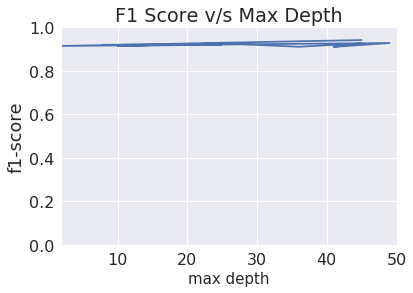

In [83]:
plot_f1_hyper(model_1)

In [66]:
%%time


grid = sp_randint(2,50)
clf =  GradientBoostingClassifier()
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model_1 = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model_1.fit(X_train_wv,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 42, 'max_depth': 19}
best est : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=19, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=42, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Accuracy: 93.86%
CPU times: user 3min 33s, sys: 606 ms, total: 3min 34s
Wall time: 51min 15s


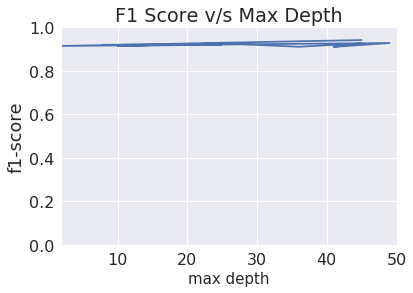

In [85]:
plot_f1_hyper(model_1)

In [67]:
i=0
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())



In [68]:
w2v_model = Word2Vec(list_of_sent,min_count=5,size= 50, workers=4)

In [69]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times :",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times : 8061
sample words  ['best', 'slim', 'jim', 'everhusband', 'love', 'spici', 'tasti', 'start', 'finish', 'dont', 'buy', 'toler', 'littl', 'healthi', 'heat', 'poor', 'luck', 'product', 'howev', 'wasabi', 'tast', 'pretti', 'even', 'boy', 'make', 'treat', 'anoth', 'level', 'like', 'obvious', 'stay', 'away', 'come', 'well', 'least', 'nutrit', 'term', 'repres', 'good', 'sourc', 'protein', 'carb', 'also', 'cholesterol', 'accur', 'ingredi', 'soybean', 'sea', 'salt', 'powder']


In [71]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 30000/30000 [00:33<00:00, 903.57it/s] 

30000
50


In [72]:
X_test_wv = sent_vectors
X_test_wv = preprocessing.normalize(X_test_wv)

Random forest:
----------

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 84.943%
Error : 15.057%
F1-Score on test set: 0.788
Precision on test set: 0.855
Recall on test set: 0.849
TPR is 0.998852893477315
TNR is 0.04895104895104895
FPR is 0.951048951048951
FNR is 0.0011471065226850204
CPU times: user 27 s, sys: 38.5 ms, total: 27 s
Wall time: 7.98 s


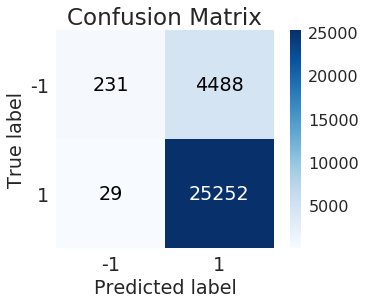

In [73]:
%%time

clf_1 = RandomForestClassifier(n_estimators= 42, max_depth = 19, class_weight = 'balanced',  bootstrap = True, 
                             oob_score= True, n_jobs= -1)
clf_1.fit(X_train_wv, Y_train);
Y_pred = clf_1.predict(X_test_wv)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

Gradient:
----------

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 84.920%
Error : 15.080%
F1-Score on test set: 0.794
Precision on test set: 0.828
Recall on test set: 0.849
TPR is 0.9943831335785768
TNR is 0.07141343504979869
FPR is 0.9285865649502013
FNR is 0.0056168664214232035
CPU times: user 29min 54s, sys: 35.9 ms, total: 29min 54s
Wall time: 29min 54s


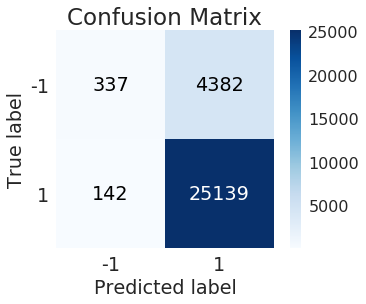

In [75]:
%%time

clf_1 = GradientBoostingClassifier(n_estimators= 42, max_depth = 19)
clf_1.fit(X_train_wv, Y_train);
Y_pred = clf_1.predict(X_test_wv)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

# TF-IDF weighted Word2Vec:
---




In [45]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [01:52<00:00, 621.33it/s]


In [52]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(70000, 100)


In [53]:
X_train_twv = tfidf_sent_vectors
print("Train Data Size: ",X_train_twv.shape)

Train Data Size:  (70000, 100)


# Random Forest:

In [54]:
%%time


grid = sp_randint(2,50)
clf = RandomForestClassifier(class_weight = 'balanced')
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model.fit(X_train_twv,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 44, 'max_depth': 20}
best est : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=44, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Accuracy: 93.63%
CPU times: user 27 s, sys: 138 ms, total: 27.1 s
Wall time: 1min 57s


Gradient Boosting:
---------

In [55]:
%%time


grid = sp_randint(2,50)
clf =  GradientBoostingClassifier()
param_rand = {'n_estimators': sorted(grid.rvs(50)),
             'max_depth': sorted(grid.rvs(50))} #params we need to try on classifier

model_1 = RandomizedSearchCV(clf,param_rand,cv=tscv,scoring='f1', n_jobs = 3)
model_1.fit(X_train_twv,Y_train)
print("Best HyperParameter: ",model.best_params_)
print("best est :",model.best_estimator_)
print("Best Accuracy: %.2f%%"%(model.best_score_*100))

Best HyperParameter:  {'n_estimators': 44, 'max_depth': 20}
best est : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=44, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Best Accuracy: 93.63%
CPU times: user 9min 27s, sys: 1.36 s, total: 9min 28s
Wall time: 2h 13min 22s


In [78]:
i=0
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    



In [79]:
w2v_model = Word2Vec(list_of_sent,min_count=5,size= 100, workers=4)


w2v_words = list(w2v_model.wv.vocab)

In [80]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [81]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [00:40<00:00, 746.84it/s]


In [88]:
tfidf_sent_vectors = preprocessing.normalize(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(30000, 100)


In [89]:
X_test_twv = tfidf_sent_vectors


# Random:

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 85.330%
Error : 14.670%
F1-Score on test set: 0.799
Precision on test set: 0.850
Recall on test set: 0.853
TPR is 0.9966773466239468
TNR is 0.08518753973299428
FPR is 0.9148124602670057
FNR is 0.0033226533760531626
CPU times: user 40.2 s, sys: 69.9 ms, total: 40.3 s
Wall time: 11.6 s


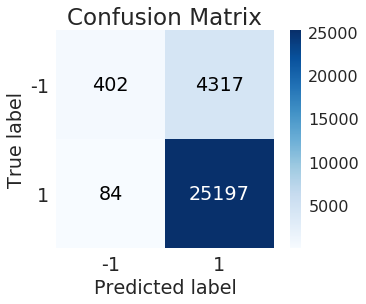

In [90]:
%%time

clf_1 = RandomForestClassifier(n_estimators= 44, max_depth = 20, class_weight = 'balanced',  bootstrap = True, 
                             oob_score= True, n_jobs= -1)
clf_1.fit(X_train_twv, Y_train);
Y_pred = clf_1.predict(X_test_twv)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]

Accuracy on test set: 85.013%
Error : 14.987%
F1-Score on test set: 0.820
Precision on test set: 0.820
Recall on test set: 0.850
TPR is 0.9702147858075234
TNR is 0.20682347955075228
FPR is 0.7931765204492477
FNR is 0.029785214192476563
CPU times: user 57min 53s, sys: 162 ms, total: 57min 53s
Wall time: 57min 53s


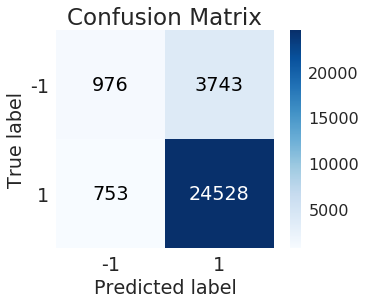

In [91]:
%%time

clf_1 = GradientBoostingClassifier(n_estimators= 44, max_depth = 20)
clf_1.fit(X_train_twv, Y_train);
Y_pred = clf_1.predict(X_test_twv)
sns.set(font_scale=1.6)
skplt.metrics.plot_confusion_matrix(Y_test ,Y_pred)
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Error : %0.3f%%"%(100-(accuracy_score(Y_test, Y_pred)*100)))

print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred, average='weighted')))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred, average = 'weighted')))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred, average = 'weighted')))


CM = confusion_matrix(Y_test ,Y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)


print("TPR is", TPR)
print("TNR is", TNR)
print("FPR is", FPR)
print("FNR is", FNR)

# SUMMARY:

In [104]:
from prettytable import PrettyTable

x = PrettyTable()


x.field_names = ["S.R.","Vectorizer","Algorithm",'{baselearners}', "{max_depth}",'Accuracy-> Train','Accuracy-> Test', "F-1 score"]

x.add_row(["(1)","BoW", "Random", 43, 46, '93.66%', '89.783%', 0.897])

x.add_row(["(2)","BoW", "Gradient", 37, 21, '93.93%', '90.273%', 0.891])

x.add_row(["(3)","tfidf", "Random", 22, 46, '93.79%', '89.536%', 0.896])

x.add_row(["(4)","tfidf", "Gradient", 47, 15, '94.00%', '90.293%', 0.890])

x.add_row(["(5)","W2V", "Random", 42, 19, '93.86%', '84.943%', 0.788])

x.add_row(["(6)","W2V", "Gradient", 42, 19, '93.86%', '84.920%', 0.794])

x.add_row(["(7)","TFIDF-W2V", "Random", 44, 20, '93.63%', '85.330%', 0.799])

x.add_row(["(8)","TFIDF-W2V", "Gradient", 44, 20, '93.63%', '85.013%', 0.820])






print(x.get_string(title = "<<<<<<<--------------------------------ENSEMBLES-------------------------------->>>>>>>"))

+---------------------------------------------------------------------------------------------------------------+
|            <<<<<<<--------------------------------ENSEMBLES-------------------------------->>>>>>>            |
+------+------------+-----------+----------------+-------------+------------------+-----------------+-----------+
| S.R. | Vectorizer | Algorithm | {baselearners} | {max_depth} | Accuracy-> Train | Accuracy-> Test | F-1 score |
+------+------------+-----------+----------------+-------------+------------------+-----------------+-----------+
| (1)  |    BoW     |   Random  |       43       |      46     |      93.66%      |     89.783%     |   0.897   |
| (2)  |    BoW     |  Gradient |       37       |      21     |      93.93%      |     90.273%     |   0.891   |
| (3)  |   tfidf    |   Random  |       22       |      46     |      93.79%      |     89.536%     |   0.896   |
| (4)  |   tfidf    |  Gradient |       47       |      15     |      94.00%      |     